# TOV Emulator to train a NN to predict Mass, Radius and Tidal Deformability of a Neutron Strar from a PP EOS - Final

### <div style= 'color: goldenrod'> Import all the required modules

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import re
import glob

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm, trange
from numba import jit

import tov_tide
%matplotlib widget

### <div style= 'color: goldenrod'> Global constants and unit conversion factors

In [3]:
msun=147660                 # Solar mass in cm given by the formula G*M_sun/c^2

c=2.9979e10                 # speed of light in cm/s (CGS)
G=6.67408e-8                # gravitational constant in cm^3/gm/s^2 (CGS)

dkm = 1.3234e-06            # conversion of MeV/fm^3 to km^-2
dcgs = 1.78e12              # factor to convert from MeV/fm^3 to gm/cm^3
conv = 8.2601e-40           # dyn/cm^2 to km^-2
cgs1=1.7827e+12             # MeV/fm3 to gms/cm3
cgs2=1.6022e+33             # MeV/fm3 to dyne/cm2

### <div style= 'color: goldenrod'> Piecewise-polytrope low-density (crust) parameters

In [4]:
# Polytropic exponents
GammaL_1 = 1.35692
GammaL_2 = 0.62223
GammaL_3 = 1.28733
GammaL_4 = 1.58425

# Polytropic constants
KL_1 = 3.99874e-8 # * pow(Msun/Length**3, GammaL_1-1)
KL_2 = 5.32697e+1 # * pow(Msun/Length**3, GammaL_2-1)
KL_3 = 1.06186e-6 # * pow(Msun/Length**3, GammaL_3-1)
KL_4 = 6.80110e-9 # * pow(Msun/Length**3, GammaL_4-1)
# notice a missing c^2 in Ki values in Table II of Read et al. 2009

# Densities at the boundaries of the piecewise polytropes
rhoL_1 = 2.62789e12
rhoL_2 = 3.78358e11
rhoL_3 = 2.44034e7
rhoL_4 = 0.0

# Pressures at the boundaries of the piecewise polytropes
pL_1 = KL_1*rhoL_1**GammaL_1
pL_2 = KL_2*rhoL_2**GammaL_2
pL_3 = KL_3*rhoL_3**GammaL_3
pL_4 = 0.0

# The exact numbers are taken from a particular crust model/table.

### <div style= 'color: goldenrod'> Few more calculations

In [ ]:
# Compute the offsets specific internal energy (epsL_i) and alphaL_i at the boundaries
# The general form used: ε(ρ)=(1+α)ρ+K/(Γ−1)ρ^Γ. Solving for alpha ensures matching across boundaries.
# Energy density needs an additive offset to enforce continuity.

epsL_4 = 0.0
alphaL_4 = 0.0
epsL_3 = (1+alphaL_4)*rhoL_3 + KL_4/(GammaL_4 - 1.)*pow(rhoL_3, GammaL_4)
alphaL_3 = epsL_3/rhoL_3 - 1.0 - KL_3/(GammaL_3 - 1.)*pow(rhoL_3, GammaL_3 -1.0)
epsL_2 = (1+alphaL_3)*rhoL_2 + KL_3/(GammaL_3 - 1.)*pow(rhoL_2, GammaL_3)
alphaL_2 = epsL_2/rhoL_2 - 1.0 - KL_2/(GammaL_2 - 1.)*pow(rhoL_2, GammaL_2 -1.0)
epsL_1 = (1+alphaL_2)*rhoL_1 + KL_2/(GammaL_2 - 1.)*pow(rhoL_1, GammaL_2)
alphaL_1 = epsL_1/rhoL_1 - 1.0 - KL_1/(GammaL_1 - 1.)*pow(rhoL_1, GammaL_1 -1.0)

# Density thresholds for high-density polytropes
rho1 = pow(10,14.7) # Break Density
rho2 = pow(10,15.0) # Break Density

# GR conversion prefactors to go from cgs pressure/energy-density units into geometric units (where G=c=1)
t_p=G/c**4
t_rho=G/c**2

### <div style= 'color: goldenrod'> Forward EOS: ρ↦(p,ε)

In [ ]:
def p_eps_of_rho(rho,logp,Gamma1,Gamma2,Gamma3):
    p1 = pow(10.0,logp)/c**2
    K1 = p1/pow(rho1,Gamma1)
    K2 = K1 * pow( rho1, Gamma1-Gamma2)
    K3 = K2 * pow( rho2, Gamma2-Gamma3)
    rho0 = pow(KL_1/K1,1.0/(Gamma1-GammaL_1)) 
    eps0 = (1.0+alphaL_1)*rho0 + KL_1/(GammaL_1-1.0)*pow(rho0,GammaL_1)
    alpha1 = eps0/rho0 - 1.0 - K1/(Gamma1 - 1.0)*pow(rho0, Gamma1 -1.0)
    eps1 = (1.0+alpha1)*rho1 + K1/(Gamma1 - 1.0)*pow(rho1, Gamma1)
    alpha2 = eps1/rho1 - 1.0 - K2/(Gamma2 - 1.0)*pow(rho1, Gamma2 -1.0)
    eps2 = (1.0+alpha2)*rho2 + K2/(Gamma2 - 1.0)*pow(rho2, Gamma2)
    alpha3 = eps2/rho2 - 1.0 - K3/(Gamma3 - 1.0)*pow(rho2, Gamma3 -1.0)
    if rho<rhoL_3:
        p = KL_4*pow(rho,GammaL_4)
        eps = (1.0+alphaL_4)*rho + KL_4/(GammaL_4-1.0)*pow(rho,GammaL_4)
    elif rhoL_3<= rho <rhoL_2:
        p = KL_3*pow(rho,GammaL_3)
        eps = (1.0+alphaL_3)*rho + KL_3/(GammaL_3-1.0)*pow(rho,GammaL_3)
    elif rhoL_2<= rho <rhoL_1:
        p = KL_2*pow(rho,GammaL_2)
        eps = (1.0+alphaL_2)*rho + KL_2/(GammaL_2-1.0)*pow(rho,GammaL_2)
    elif rhoL_1<= rho <rho0:
        p = KL_1*pow(rho,GammaL_1)
        eps = (1.0+alphaL_1)*rho + KL_1/(GammaL_1-1.0)*pow(rho,GammaL_1)
    elif rho0<= rho <rho1:
        p = K1*pow(rho,Gamma1)
        eps = (1.0+alpha1)*rho + K1/(Gamma1-1.0)*pow(rho,Gamma1)
    elif rho1<= rho <rho2:
        p = K2*pow(rho,Gamma2)
        eps = (1.0+alpha2)*rho + K2/(Gamma2-1.0)*pow(rho,Gamma2)
    else:
        p = K3*pow(rho,Gamma3)
        eps = (1.0+alpha3)*rho + K3/(Gamma3-1.0)*pow(rho,Gamma3)
    return p*c**2, eps*c**2

### <div style= 'color: goldenrod'> Inverse EOS: p↦ε

In [8]:
@jit(nopython=True)
def eps(p,logp,Gamma1,Gamma2,Gamma3):
    p1 = pow(10.0,logp)/c**2
    p*=1/c**2
    K1 = p1/pow(rho1,Gamma1)
    K2 = K1 * pow( rho1, Gamma1-Gamma2)
    K3 = K2 * pow( rho2, Gamma2-Gamma3)
    rho0 = pow(KL_1/K1,1.0/(Gamma1-GammaL_1))
    eps0 = (1.0+alphaL_1)*rho0 + KL_1/(GammaL_1-1.0)*pow(rho0,GammaL_1)
    alpha1 = eps0/rho0 - 1.0 - K1/(Gamma1 - 1.0)*pow(rho0, Gamma1 -1.0)
    eps1 = (1.0+alpha1)*rho1 + K1/(Gamma1 - 1.0)*pow(rho1, Gamma1)
    alpha2 = eps1/rho1 - 1.0 - K2/(Gamma2 - 1.0)*pow(rho1, Gamma2 -1.0)
    eps2 = (1.0+alpha2)*rho2 + K2/(Gamma2 - 1.0)*pow(rho2, Gamma2)
    alpha3 = eps2/rho2 - 1.0 - K3/(Gamma3 - 1.0)*pow(rho2, Gamma3 -1.0)
    p0 = K1*pow(rho0,Gamma1)
    p2 = K3*pow(rho2,Gamma3)
    if  p<pL_3:
        rho = pow(p/KL_4,1/GammaL_4)
        eps = (1.0+alphaL_4)*rho + KL_4/(GammaL_4-1.0)*pow(rho,GammaL_4)
    elif pL_3<= p <pL_2:
        rho = pow(p/KL_3,1/GammaL_3)
        eps = (1.0+alphaL_3)*rho + KL_3/(GammaL_3-1.0)*pow(rho,GammaL_3)
    elif pL_2<= p <pL_1:
        rho = pow(p/KL_2,1/GammaL_2)
        eps = (1.0+alphaL_2)*rho + KL_2/(GammaL_2-1.0)*pow(rho,GammaL_2)
    elif  pL_1<p <p0:
        rho = pow(p/KL_1,1/GammaL_1)
        eps = (1.0+alphaL_1)*rho + KL_1/(GammaL_1-1.0)*pow(rho,GammaL_1)
    elif p0<= p <p1:
        rho = pow(p/K1,1/Gamma1)
        eps = (1.0+alpha1)*rho + K1/(Gamma1-1.0)*pow(rho,Gamma1)
    elif p1<= p <p2:
        rho = pow(p/K2,1/Gamma2)
        eps = (1.0+alpha2)*rho + K2/(Gamma2-1.0)*pow(rho,Gamma2)
    else:
        rho = pow(p/K3,1/Gamma3)
        eps = (1.0+alpha3)*rho + K3/(Gamma3-1.0)*pow(rho,Gamma3)
    return eps*c**2

### <div style= 'color: goldenrod'> The TOV Integrator

In [9]:
# def TOV(logrho_c,theta):
#     logp,Gamma1,Gamma2,Gamma3 = theta[0],theta[1],theta[2],theta[3]
#     dr=100
#     rho_c = pow(10,logrho_c)
#     m=0.0
#     r=0.1
#     p,e = p_eps_of_rho(rho_c,theta[0],theta[1],theta[2],theta[3])
#     p*=t_p
#     e*=t_p
       
#     while p >= 0:
#         p += -(e+p)*(m+4.0*np.pi*(r**3.0)*p)*dr/(r*(r-2.0*m))
#         if p <= 0:
#             break               
#         m += 4.0*np.pi*(r**2.0)*e*dr
#         r += dr
#         e = eps(p/t_p,theta[0],theta[1],theta[2],theta[3])*t_p
#         M, R, TD = tov_tide.tov_tide(e, p, ) # energy_density, pressure, 
            
#     return m/msun, r/1e5, TD

In [ ]:
def TOV(logrho_c, theta, compute_tidal=True):
    logp, Gamma1, Gamma2, Gamma3 = theta
    dr = 100.0 # in meters

    rho_c = 10**logrho_c
    r = 0.1
    m = 0.0

    p, e = p_eps_of_rho(rho_c, logp, Gamma1, Gamma2, Gamma3)
    p *= t_p
    e *= t_p

    # --- store profiles ---
    p_prof = []
    e_prof = []
    r_prof = []
    m_prof = []

    while p > 0:
        p_prof.append(p)
        e_prof.append(e)
        r_prof.append(r)
        m_prof.append(m)

        dp = -(e + p) * (m + 4*np.pi*r**3*p) / (r*(r - 2*m))
        p += dp * dr
        if p <= 0:
            break

        m += 4*np.pi*r**2 * e * dr
        r += dr
        e = eps(p/t_p, logp, Gamma1, Gamma2, Gamma3) * t_p

    # final mass and radius
    M = m / msun
    R = r / 1e5

    if not compute_tidal:
        return M, R

    # --- prepare inputs for Fortran ---
    p_prof = np.array(p_prof, dtype=np.float64)
    e_prof = np.array(e_prof, dtype=np.float64)

    # Fortran expects central pressure at index N
    p_prof = p_prof[::-1]
    e_prof = e_prof[::-1]

    pc = p_prof[-1]
    N = len(p_prof)

    # --- tidal deformability ---
    M_tide, R_tide, Lambda = tov_tide.tov_tide(
        e_prof,
        p_prof,
        pc
    )
    return M, R, Lambda # Returns true lambda (not log lambda)


### <div style= 'color: goldenrod'> Produce a Mass-Radius curve and Tidal deformability vs Compactness plot for a single EOS

In [ ]:
logrho_c_array=np.linspace(14.5,15.4,100)
theta=[34.495, 3.446, 3.572, 2.887] #MPA1

seq=[]
Lambda_seq = []
for logrho_c in logrho_c_array:
    m,r, Lambda=TOV(logrho_c,theta, compute_tidal=True)
    seq.append((m,r))
    Lambda_seq.append(Lambda)
    
seq=np.array(seq)
Lambda_seq = np.array(Lambda_seq)

compactness = seq[:, 0] * 1.4766 / seq[:, 1] # Compactness in geometric units

# M-R PLot
plt.figure()
plt.plot(seq[:,1],seq[:,0])
plt.grid()
plt.xlabel('Radius (km)')
plt.ylabel(r'$M \, (M_{\odot})$')
plt.show()

# Log TD plot
plt.figure()
plt.plot(compactness, Lambda_seq)
plt.yscale("log")
plt.grid()
plt.xlabel(r"$Compactness (M/R) $")
plt.ylabel(r"$\Lambda$")
plt.show()


### <div style= 'color: slateblue'>Create dataset of EOS parameter samples & run TOV to create targets

In [11]:
# Number of EOS samples
NUM_SAMPLES = 400000 
# Directory to save/load dataset and models 
save_dir = f"Copied over from Cluster/{NUM_SAMPLES}files"

In [ ]:
# COMENTED OUT TO BE ABLE TO RUN ALL CELLS AT ONCE. CODE WORKS PERFECTLY FINE TO CREATE A DATASET

EOS_params = np.random.uniform( low=[1.4, 1.4, 1.4], 
                                high=[5., 5., 5.], 
                                size=(NUM_SAMPLES, 3)
                                )

logrho_c_samples = np.random.uniform(14.5, 15.4, size=(NUM_SAMPLES, 1))
logp_samples = np.random.uniform(33.5, 34.8, size=(NUM_SAMPLES, 1))

MRL_data = []

for i in trange(NUM_SAMPLES, desc="Solving TOV"):
    logrho_c = logrho_c_samples[i, 0]
    logp = logp_samples[i, 0]
    params = EOS_params[i]

    M, R, Lambda = TOV(
        logrho_c,
        [logp, params[0], params[1], params[2]],
        compute_tidal = True
        )
    MRL_data.append([M, R, Lambda])

MRL_data = np.array(MRL_data)

# ==========================================================
# FILTER UNPHYSICAL OUTPUTS PRODUCED BY EXTREMELY STIFF EOSs
# ==========================================================

M = MRL_data[:, 0]
R = MRL_data[:, 1]
Lambda = MRL_data[:, 2]

mask = (
    np.isfinite(M) &
    np.isfinite(R) &
    (M > 0.15) & (M < 3.5) &
    (R > 6.0) & (R < 25.0) &
    (Lambda > 0) & (Lambda < 1e6)
)

EOS_data = np.hstack([
    logrho_c_samples[mask],
    logp_samples[mask],
    EOS_params[mask],
    MRL_data[mask]
])

print(f"Kept {EOS_data.shape[0]} / {NUM_SAMPLES} samples")

# Save cleaned dataset
os.makedirs(save_dir, exist_ok=True)

np.save(os.path.join(save_dir, f"EOS_dataset_{NUM_SAMPLES}files.npy"), EOS_data)
print("Datasets created and saved!")

### <div style= 'color: goldenrod'> PyTorch ML pipeline — load data for sanity check

In [12]:
# Load dataset
data = np.load(os.path.join(save_dir, f"EOS_dataset_{NUM_SAMPLES}files.npy"))
# data = np.load(os.path.join(save_dir, f"EOS_dataset_full.npy"))

# Checking the dataset with added column headers
Column_headers = ['log_rho_c', 'log_p', 'Gamma1', 'Gamma2', 'Gamma3', 'Mass_Msun', 'Radius_km', 'TD']
df = pd.DataFrame(data, columns=Column_headers)
# df.head()
# Max and min values for each column
df.describe()

# Radius should be within 6 and 24km
# Tidal deformability must be logged

,log_rho_c,log_p,Gamma1,Gamma2,Gamma3,Mass_Msun,Radius_km,TD
count,313204.000000,313204.000000,313204.000000,313204.000000,313204.000000,313204.000000,313204.000000,313204.000000
mean,15.026349,34.230787,3.186065,3.244827,3.205531,1.361733,11.174885,53028.000746
std,0.232651,0.357552,1.032441,1.033178,1.039032,0.799108,2.477591,150669.864586
min,14.500003,33.500007,1.400052,1.400004,1.400022,0.150316,6.153001,0.366197
25%,14.849202,33.948744,2.288948,2.361345,2.304534,0.624121,9.516001,10.007676
50%,15.044499,34.263051,3.170591,3.264420,3.209259,1.277025,10.788001,348.383411
75%,15.223301,34.536595,4.079704,4.140514,4.106054,2.054865,12.287251,13118.709902
max,15.399997,34.799998,4.999995,4.999995,4.999993,3.287210,24.999001,999915.422706


### <div style= 'color: goldenrod'> PyTorch ML pipeline — prepare data

In [ ]:
# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)
BATCH_SIZE = 256

# Split into training and validation sets
split_idx = int(0.8 * len(data))
train_data = data[:split_idx]
val_data = data[split_idx:]

# Convert to Tensor
# Inputs: Cols 0 to 4 (5 features: log_rho_c, log_p, Gamma1, Gamma2, Gamma3)
# Output: Col 5 - 7 (Mass, Radius, Tidal Deformability)
X_eos_train = torch.tensor(train_data[:, :5], dtype=torch.float32)
y_eos_train = torch.tensor(train_data[:, 5:8], dtype=torch.float32)

X_eos_val = torch.tensor(val_data[:, :5], dtype=torch.float32)
y_eos_val = torch.tensor(val_data[:, 5:8], dtype=torch.float32)

# Normalize using Z-Score on all the inputs
X_eos_mean = X_eos_train.mean(dim=0, keepdim=True)
X_eos_std = X_eos_train.std(dim=0, keepdim=True)
# Save them:
torch.save(X_eos_mean, os.path.join(save_dir, "X_eos_mean.pt"))
torch.save(X_eos_std, os.path.join(save_dir, "X_eos_std.pt"))
print("Normalization statistics saved.")
X_train_norm = (X_eos_train - X_eos_mean) / X_eos_std
X_val_norm = (X_eos_val - X_eos_mean) / X_eos_std

# 4. Separate Mass, Radius and TD
y_mass_train, y_radius_train, y_td_train = y_eos_train[:, 0:1], y_eos_train[:, 1:2], y_eos_train[:, 2:3]
y_mass_val, y_radius_val, y_td_val = y_eos_val[:, 0:1], y_eos_val[:, 1:2], y_eos_val[:, 2:3]

# 5.1  Constant Scaling on Mass (M)
MASS_SCALE = 3.5
y_mass_train_norm = y_mass_train / MASS_SCALE
y_mass_val_norm = y_mass_val / MASS_SCALE

# 5.2. Normalize using Constant Scaling on Radius (R)
RADIUS_SCALE = 25.0
y_radius_train_norm = y_radius_train / RADIUS_SCALE
y_radius_val_norm = y_radius_val / RADIUS_SCALE

# 5.3 Log Scale TD
y_td_train_norm = torch.log10(y_td_train)
y_td_val_norm = torch.log10(y_td_val)

# 6. --- Recombine Outputs ---
y_train_norm = torch.cat((y_mass_train_norm, y_radius_train_norm, y_td_train_norm), dim=1)
y_val_norm = torch.cat((y_mass_val_norm, y_radius_val_norm, y_td_val_norm), dim=1)


### <div style= 'color: orange'> Range of values of the parameters before scaling and normalizing

In [ ]:
print("Log Central Density min/max:", np.round(train_data[:, 0].min(), 3), np.round(train_data[:, 0].max(), 3))
print("Log Central Pressure min/max:", np.round(train_data[:, 1].min(), 3), np.round(train_data[:, 1].max(), 3))
print("Gamma 1 min/max:", np.round(train_data[:, 2].min(), 3), np.round(train_data[:, 2].max(), 3))
print("Gamma 2 min/max:", np.round(train_data[:, 3].min(), 3), np.round(train_data[:, 3].max(), 3))
print("Gamma 3 min/max:", np.round(train_data[:, 4].min(), 3), np.round(train_data[:, 4].max(), 3))

print("Mass min/max:", np.round(train_data[:, 5].min(), 3), np.round(train_data[:, 5].max(), 3))
print("Radius min/max:", np.round(train_data[:, 6].min(), 3), np.round(train_data[:, 6].max(), 3))
print("Tidal Deformability min/max:", np.round(train_data[:, 7].min(), 3), np.round(train_data[:, 7].max(), 3))

train_data.shape

### <div style= 'color: orange'> Range of values of the parameters after scaling and normalizing

In [ ]:
print("Log Central Density min/max:", np.round(X_train_norm[:, 0].min(), 3), np.round(X_train_norm[:, 0].max(), 3))
print("Log Central Pressure min/max:", np.round(X_train_norm[:, 1].min(), 3), np.round(X_train_norm[:, 1].max(), 3))
print("Gamma 1 min/max:", np.round(X_train_norm[:, 2].min(), 3), np.round(X_train_norm[:, 2].max(), 3))
print("Gamma 2 min/max:", np.round(X_train_norm[:, 3].min(), 3), np.round(X_train_norm[:, 3].max(), 3))
print("Gamma 3 min/max:", np.round(X_train_norm[:, 4].min(), 3), np.round(X_train_norm[:, 4].max(), 3))

print("Mass min/max:", np.round(y_train_norm[:, 0].min(), 3), np.round(y_train_norm[:, 0].max(), 3))
print("Radius min/max:", np.round(y_train_norm[:, 1].min(), 3), np.round(y_train_norm[:, 1].max(), 3))
print("Tidal Deformability min/max:", np.round(y_train_norm[:, 2].min(), 3), np.round(y_train_norm[:, 2].max(), 3))

train_data.shape

### <div style= 'color: goldenrod'> NN Definition

In [13]:
class ResNetBlock(nn.Module):
    def __init__(self, hidden_dim, auxiliary_dim=1):
        super().__init__()
        # We accept the hidden state + the auxiliary Central Pressure injection
        self.fc = nn.Linear(hidden_dim + auxiliary_dim, hidden_dim)
        self.act = nn.GELU() # Gaussian Error Linear Unit
    
    def forward(self, x, cp):
        # Concatenate Central Pressure to the input of the layer
        combined = torch.cat([x, cp], dim=1)
        out = self.act(self.fc(combined))
        return x + out # Residual connection

class PhysicsEmulator(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512): 
        super().__init__()
        # Separate EOS inputs from Central Pressure
        # input_dim is 5: (4 EOS params + 1 Central Pressure)
        self.eos_dim = input_dim - 1 
        
        # 1. Initial encoding of EOS parameters only: 
        self.input_layer = nn.Linear(self.eos_dim, hidden_dim)
        
        # 2. Deep Residual Layers with Central Pressure Injection
        self.block1 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block2 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block3 = ResNetBlock(hidden_dim, auxiliary_dim=1)
        self.block4 = ResNetBlock(hidden_dim, auxiliary_dim=1)

        # 3. Output layers
        self.final_layer = nn.Sequential(
            nn.Linear(hidden_dim + 1, hidden_dim // 2), # Inject Central Pressure one last time
            nn.GELU(),                                      # 513 --> 256
            nn.Linear(hidden_dim // 2, 3)                   # Output: 256 --> 3
        )
        
    def forward(self, x):
        # Split input into EOS params and Central Pressure
        # Central Pressure is the second column
        cp = x[:, 1:2]
        # EOS parameters are the remaining columns
        eos_params = torch.cat([x[:, 0:1], x[:, 2:]], dim=1)

        # 1. Encode EOS
        x_hidden = self.input_layer(eos_params)             # Input: 5 --> 512

        # 2. Central Pressure-Injected Residual Flow: Pass through blocks, injecting Central Pressure at each step
        x_hidden = self.block1(x_hidden, cp)              # 512 + 1 --> 512
        x_hidden = self.block2(x_hidden, cp)              # 512 + 1 --> 512
        x_hidden = self.block3(x_hidden, cp)              # 512 + 1 --> 512
        x_hidden = self.block4(x_hidden, cp)              # 512 + 1 --> 512
        
        # 3. Final Prediction
        # Concatenate Central Pressure one last time for the read-out
        combined_final = torch.cat([x_hidden, cp], dim=1) # 512 + 1 = 513
        return self.final_layer(combined_final)             

### <div style= 'color: goldenrod'> Train the model (batch-wise gradient descent) and plot losses

In [ ]:
# --- Helper function for plotting ---
def plot_and_save_losses(train_losses, val_losses, filename="loss_curve.png"):
    """Plots training and validation loss and saves the figure."""
    epochs = range(len(train_losses))

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.plot(epochs, val_losses, label='Validation Loss', color='red')
    
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Huber Loss (Normalized)')
    plt.yscale('log') # Use log scale for clearer visualization of small losses
    plt.legend()
    plt.grid(True, which="both", ls="--")
    
    try:
        plt.savefig(os.path.join(save_dir, filename))
        print(f"Loss plot saved to {filename}", flush=True)
    except Exception as e:
        print(f"ERROR saving plot: {e}", flush=True)
    plt.close()
# --------------------------------------------------------------------------


model = PhysicsEmulator().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=1000, eta_min=1e-7)
criterion = nn.HuberLoss()

# ==============================================================================
# 5. TRAINING
# ==============================================================================
# Ensure Mass and Radius are Torch Tensors (it might be a numpy array currently)
if isinstance(y_train_norm, np.ndarray):
    y_train_norm = torch.from_numpy(y_train_norm).to(torch.float32)
if isinstance(y_val_norm, np.ndarray):
    y_val_norm = torch.from_numpy(y_val_norm).to(torch.float32)

# Update your DataLoaders
train_loader = DataLoader(TensorDataset(X_train_norm, y_train_norm), batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_norm, y_val_norm), batch_size=BATCH_SIZE, shuffle=False)
epochs = 1000

best_val_loss = float('inf')
patience = 500  # Number of epochs to wait for improvement before stopping
patience_counter = 0

# 1. ADD STORAGE LISTS
train_losses = []
val_losses = []
# Ensure MASS_SCALE and RADIUS_SCALE are defined globally or passed in if running as a function
# If you didn't define save_dir, model will save in current directory.

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_b, y_b in train_loader:
        X_b, y_b = X_b.to(DEVICE), y_b.to(DEVICE)
        optimizer.zero_grad()
        pred = model(X_b)
        loss = criterion(pred, y_b)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_b, y_b in val_loader:
            X_b, y_b = X_b.to(DEVICE), y_b.to(DEVICE)
            pred = model(X_b)
            loss = criterion(pred, y_b)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    scheduler.step()
    
    # 2. APPEND LOSSES
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Early Stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model weights
        best_model_state = model.state_dict()

    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    if epoch % 100 == 0:
        # Calculate the Approximate Physical Error in km
        radius_error_km = np.sqrt(2 * val_loss) * RADIUS_SCALE 
        mass_error = np.sqrt(2 * val_loss) * MASS_SCALE
        td_error_log = np.sqrt(2 * val_loss)  # Since td is log-scaled, this is in log units

        print(f"Epoch {epoch} | Train Loss: {train_loss:.6e} | Val Loss: {val_loss:.6e} | Approx Radius Error: {radius_error_km:.4f} km | Approx Mass Error: {mass_error:.4f} | Approx TD error: {td_error_log:.4f}", flush=True)

        # 3. PLOT AND SAVE PERIODICALLY
        # Plot every 50 epochs (or choose a different interval)
        if epoch % 500 == 0 and epoch > 0:
            plot_and_save_losses(train_losses, val_losses, filename=f"loss_curve_epoch{epoch}.png")

# Restore best model
model.load_state_dict(best_model_state)
print(f"Training finished. Best validation loss: {best_val_loss:.10f}")

# 4. FINAL PLOT after training finishes
plot_and_save_losses(train_losses, val_losses, filename="loss_curve_final.png")
torch.save(model.state_dict(), os.path.join(save_dir, "Best_EOS_Model.pth"))

### <div style= 'color: goldenrod'> Evaluate PIRNN for grid of CD + CP + EOS parameters

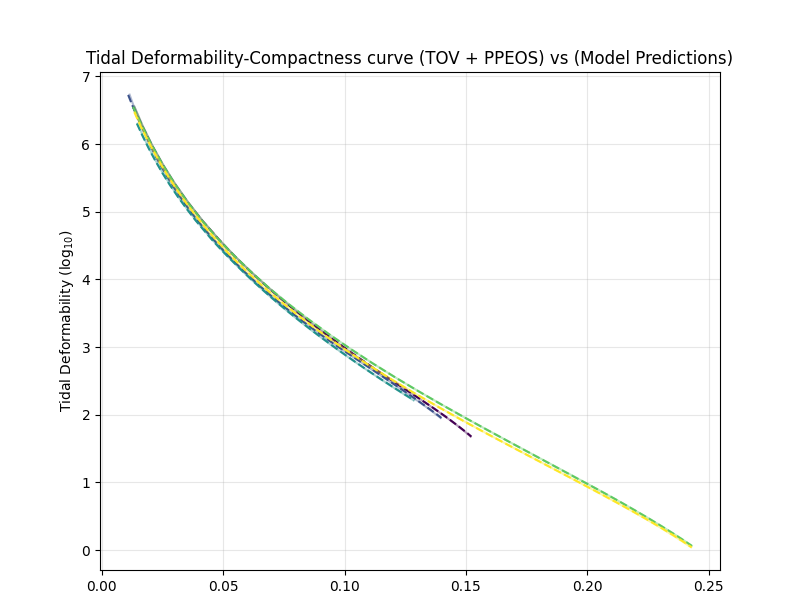

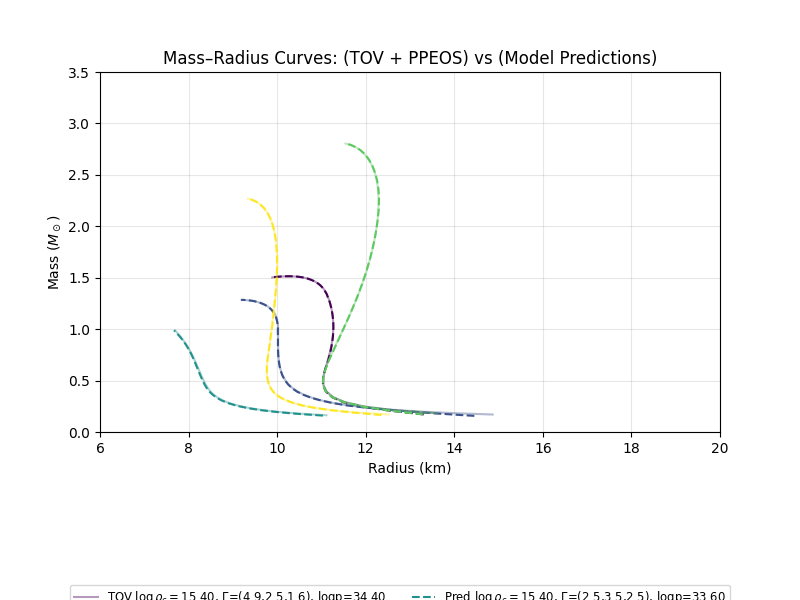

In [37]:
import itertools
import random

# ==============================================================================
# 1. CONFIGURATION & HELPERS
# ==============================================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RADIUS_SCALE = 25.0
MASS_SCALE = 3.5

MODEL_NO = 2

# ==============================================================================
# 2. SET RANGES FOR PARAMETERS OF THE EOS FOR THE CURVES TO BE TESTED
# ==============================================================================
Gamma1_values = [1.6, 2.5, 3.5, 4.5, 4.9] # Values outside the training range would be extrapolation
Gamma2_values = [1.6, 2.5, 3.5, 4.5, 4.9]
Gamma3_values = [1.6, 2.5, 3.5, 4.5, 4.9]

logp_values = [33.6, 34.0, 34.4, 34.8]
logrho_c_array = np.linspace(14.5, 15.4, 60) # sample different central densities

# Randomly select 5 combinations of (Γ1,Γ2,Γ3,logp)
param_combinations = list(itertools.product(Gamma1_values, Gamma2_values, Gamma3_values, logp_values))
sampled_combinations = random.sample(param_combinations, 5)  # 5 random combos

# ==============================================================================
# 3. PREPARE MODEL & SCALERS
# ==============================================================================
# Call model to device
model = PhysicsEmulator().to(DEVICE)
model.load_state_dict(torch.load(os.path.join(save_dir, "Best_EOS_Model.pth"), map_location=DEVICE))
model.eval()

# Load the means and stds for normalization
X_mean = torch.load(os.path.join(save_dir, "X_eos_mean.pt")).to(DEVICE)
X_std = torch.load(os.path.join(save_dir, "X_eos_std.pt")).to(DEVICE)

# Initialize lists to store results
predicted_mass = []
predicted_radius = []
predicted_td = []
original_mass = []
original_radius = []
original_td = []

# ==============================================================================
# 4. EVALUATION AND PLOT LOOP
# ==============================================================================
fig1, ax1 = plt.subplots(figsize=(8, 6))
fig2, ax2 = plt.subplots(figsize=(8, 6))

colors = plt.cm.viridis(np.linspace(0, 1, len(sampled_combinations)))


for color, (Gamma1, Gamma2, Gamma3, logp) in zip(colors, sampled_combinations):
    predicted_mass_single = []
    predicted_radius_single = []
    predicted_td_single = []

    original_mass_single = []
    original_radius_single = []
    original_td_single = []

    for logrho_c in logrho_c_array:
        # Normalize all parameters using Z-Score
        input_eos_params = torch.tensor([[logrho_c, logp, Gamma1, Gamma2, Gamma3]], dtype=torch.float32).to(DEVICE)
        input_norm = ((input_eos_params - X_mean) / X_std).to(DEVICE)

        # Predict
        with torch.no_grad():
            prediction = model(input_norm)

        # Bring predictions to cpu
        pred = prediction.cpu().numpy()

        M_pred_denorm = float(pred[0, 0] * MASS_SCALE)
        R_pred_denorm = float(pred[0, 1] * RADIUS_SCALE)
        TD_pred_log = float(pred[0, 2])  # Keep log scaling

        # Remove unphysical predictions
        if not (
            np.isfinite(M_pred_denorm) and
            np.isfinite(R_pred_denorm) and
            np.isfinite(TD_pred_log) and
            0.15 < M_pred_denorm < 3.5 and
            6.0 < R_pred_denorm < 25.0 and
            0 < TD_pred_log < 10.0

        ):
            continue

        # Original TOV solution for comparison
        M_orig, R_orig, TD_orig = TOV(logrho_c, [logp, Gamma1, Gamma2, Gamma3])

        # Remove unphysical values
        if not (
            np.isfinite(M_orig) and
            np.isfinite(R_orig) and
            np.isfinite(TD_orig) and
            0.15 < M_orig < 3.5 and
            6.0 < R_orig < 25.0 and
            0 < np.log10(TD_orig) < 10.0
        ):
            continue

        # Store single curve results
        predicted_mass_single.append(M_pred_denorm)
        predicted_radius_single.append(R_pred_denorm)
        original_mass_single.append(M_orig)
        original_radius_single.append(R_orig)
        predicted_td_single.append(TD_pred_log)
        original_td_single.append(np.log10(TD_orig))

    # Append to overall lists
    predicted_mass.append(predicted_mass_single)    
    predicted_radius.append(predicted_radius_single)
    original_mass.append(original_mass_single)
    original_radius.append(original_radius_single)
    original_td.append(original_td_single)
    predicted_td.append(predicted_td_single)

    orig_M = np.array(original_mass_single)
    orig_R = np.array(original_radius_single)
    pred_M = np.array(predicted_mass_single)
    pred_R = np.array(predicted_radius_single)

    label = rf"$\log\rho_c= {logrho_c:.2f}$, Γ=({Gamma1},{Gamma2},{Gamma3}), logp={logp:.2f}"

    # Plot M-R curves
    ax1.plot(original_radius_single, original_mass_single, '-', color=color, alpha=0.4, label=f"TOV {label}")
    ax1.plot(predicted_radius_single, predicted_mass_single, '--', color=color, label=f"Pred {label}")
    
    ax2.plot(orig_M / orig_R, original_td_single, "-", color=color, alpha=0.4, label=f"TOV + PPEOS {label}")
    ax2.plot(pred_M / pred_R, predicted_td_single, "--", color=color, label=f"Model Prediction {label}")

    # Formatting
    ax1.set_title("Mass–Radius Curves: (TOV + PPEOS) vs (Model Predictions)")
    ax1.set_xlabel("Radius (km)")
    ax1.set_ylabel(r"Mass ($M_\odot$)")
    ax1.set_xlim(6, 20)
    ax1.set_ylim(0, 3.5)
    ax1.grid(alpha=0.3)

    ax2.set_title("Tidal Deformability-Compactness curve (TOV + PPEOS) vs (Model Predictions)")
    ax2.set_xlabel(r"Compactness ($M/R$)")
    ax2.set_ylabel("Tidal Deformability (log$_{10}$)")
    ax2.grid(alpha=0.3)

fig1.legend(
    loc="lower center",
    bbox_to_anchor=(0.5, -0.18),
    fontsize="small",
    ncol=2
)
fig1.subplots_adjust(bottom=0.28)
fig2.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.18),
    fontsize="small",
    ncol=2
)
fig2.subplots_adjust(bottom=0.05)

fig1.savefig(os.path.join(save_dir, f"MR_unseen{MODEL_NO}.svg"), bbox_inches="tight")
fig2.savefig(os.path.join(save_dir, f"TD_compactness_unseen_{MODEL_NO}.svg"), bbox_inches="tight")

plt.show()

### <div style= 'color: goldenrod'> Model Metrics

In [35]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

orig_radius_all = np.concatenate(original_radius)
pred_radius_all = np.concatenate(predicted_radius)

orig_mass_all = np.concatenate(original_mass)
pred_mass_all = np.concatenate(predicted_mass)

orig_td_all = np.concatenate(original_td)
pred_td_all = np.concatenate(predicted_td)

mae_radius = mean_absolute_error(orig_radius_all, pred_radius_all)
rmse_radius = np.sqrt(mean_squared_error(orig_radius_all, pred_radius_all))
r2_radius = r2_score(orig_radius_all, pred_radius_all)

mae_mass = mean_absolute_error(orig_mass_all, pred_mass_all)
rmse_mass = np.sqrt(mean_squared_error(orig_mass_all, pred_mass_all))
r2_mass = r2_score(orig_mass_all, pred_mass_all)

mae_td = mean_absolute_error(orig_td_all, pred_td_all)
rmse_td = np.sqrt(mean_squared_error(orig_td_all, pred_td_all))
r2_td = r2_score(orig_td_all, pred_td_all)

norm_rmse = np.mean([
    rmse_radius / np.mean(orig_radius_all),
    rmse_mass / np.mean(orig_mass_all),
    rmse_td / np.mean(orig_td_all)
])

print(f"Radius:  MAE={mae_radius:.4f}, RMSE={rmse_radius:.4f}, R²={r2_radius:.4f}")
print(f"Mass:  RMSE={rmse_mass:.4f}, R²={r2_mass:.4f}")
print(f"TD:  MAE={mae_td:.4f}, RMSE={rmse_td:.4f}, R²={r2_td:.4f}")
print(f"Combined normalized RMSE = {norm_rmse:.4f}")

Radius:  MAE=0.0120, RMSE=0.0351, R²=0.9999
Mass:  RMSE=0.0017, R²=1.0000
TD:  MAE=0.0015, RMSE=0.0020, R²=1.0000
Combined normalized RMSE = 0.0016


In [36]:
# -----------------------------
# Save metrics to a text file
# -----------------------------
output_file = os.path.join(save_dir, f"Model_metrics_{MODEL_NO}.txt")

with open(output_file, "w") as f:
    f.write("Mass, Radius and TD prediction metrics\n")
    f.write("======================================\n")

    f.write("Mass Prediction Metrics:\n")
    f.write(f"MAE   : {mae_mass:.6f}\n")
    f.write(f"RMSE  : {rmse_mass:.6f}\n")
    f.write(f"R^2   : {r2_mass:.6f}\n")
    f.write("\n")

    f.write("Radius Prediction Metrics:\n")
    f.write(f"MAE   : {mae_radius:.6f}\ n")
    f.write(f"RMSE  : {rmse_radius:.6f}\n")
    f.write(f"R^2   : {r2_radius:.6f}\n")
    f.write("\n")

    f.write("Tidal Deformability Prediction Metrics:\n")
    f.write(f"MAE   : {mae_td:.6f}\n")
    f.write(f"RMSE  : {rmse_td:.6f}\n")
    f.write(f"R^2   : {r2_td:.6f}\n")
    f.write("\n")

    f.write(f"Norm RMSE : {norm_rmse:.6f}\n")

print(f"Metrics saved to {output_file}")


Metrics saved to Copied over from Cluster/400000files/Model_metrics_1.txt
